In [1]:
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,\
    UpSampling2D, Lambda, Activation, Flatten, Reshape, merge
from keras.layers.normalization import BatchNormalization
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from PIL import Image
import scipy.misc
import matplotlib.pyplot as plt
from scipy.misc import imsave
import bcolz

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test_, y_test_) = mnist.load_data()
x_train = (x_train.astype(np.float32)/255.0) #* 2.0 - 1.0
x_train = np.expand_dims(x_train, axis=3)

In [3]:
discriminator_model = Sequential()
discriminator_model.add(Conv2D(256, (5,5), strides=(2,2), padding='same', 
                  activation=LeakyReLU(), input_shape=(28, 28, 1)))
discriminator_model.add(Conv2D(512, (5,5), strides=(2,2), padding='same', 
                  activation=LeakyReLU()))
discriminator_model.add(Flatten())
discriminator_model.add(Dense(256, activation=LeakyReLU()))
discriminator_model.add(Dense(1, activation = LeakyReLU()))
discriminator_model.compile(Adam(0.000001), loss="binary_crossentropy")

/usr/local/lib/python3.5/dist-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


In [4]:
generator_model = Sequential()
generator_model.add(Dense(512*7*7, activation='relu', input_dim=100))
generator_model.add(BatchNormalization())
generator_model.add(Reshape((7, 7, 512)))
generator_model.add(UpSampling2D())
generator_model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
generator_model.add(BatchNormalization())
generator_model.add(UpSampling2D())
generator_model.add(Conv2D(32, (3,3), padding='same', activation='relu'))
generator_model.add(BatchNormalization())
generator_model.add(Conv2D(1, (1,1), padding='same', activation='tanh'))

In [5]:
'''Train discriminator for 1 epoch as a start'''
init_data = len(x_train)

real = np.random.permutation(x_train)[:init_data]
fake = generator_model.predict(np.random.rand(init_data,100))
x_init = np.concatenate((real,fake))

real_label = np.zeros((init_data,1))
fake_label = np.ones((init_data,1))
y_init = np.concatenate((real_label,fake_label))
discriminator_model.fit(x_init,y_init,batch_size=128,epochs=1)

Epoch 1/1
120000/120000 [==============================] - 30s - loss: 1.9492    


In [6]:
model = Sequential([generator_model, discriminator_model])
model.compile(Adam(0.000001), loss = "binary_crossentropy")

In [7]:
num_iterations = 250
real_per_iter = 1000
fake_per_iter = 1000

real_label = np.zeros((real_per_iter,1))
fake_label = np.ones((fake_per_iter,1))
y_mini = np.concatenate((real_label,fake_label))

discriminator_loss = []
generator_loss = []
num_data = len(x_train)
repeat_discriminator = 1
repeat_generator = 1

In [46]:
num_iterations = 100
real_per_iter = 1000
fake_per_iter = 1000
repeat_discriminator = 10
repeat_generator = 0
for i in range(num_iterations):
    print('Iteration #%d' % i)
    real = x_train[np.random.randint(0,high=num_data,size=real_per_iter)]
    fake = generator_model.predict(np.random.rand(fake_per_iter,100))
    x_mini = np.concatenate((real, fake))
    '''Training discriminator'''
    discriminator_loss.append(discriminator_model.train_on_batch(x_mini,y_mini))
    for k in range(repeat_discriminator):
        real_ = x_train[np.random.randint(0,high=num_data,size=real_per_iter)]
        fake_ = generator_model.predict(np.random.rand(fake_per_iter,100))
        x_mini_ = np.concatenate((real, fake))
        discriminator_loss.append(discriminator_model.train_on_batch(x_mini_,y_mini))
    
    '''Freeze discriminator'''
    discriminator_model.trainable = False
    for layer in discriminator_model.layers:
        layer.trainable = False
    
    '''Training generator'''
    generator_x = np.random.rand(fake_per_iter*2,100)
    generator_y = np.zeros((fake_per_iter*2,1))
    generator_loss.append(model.train_on_batch(generator_x, generator_y))
    for k in range(repeat_generator):
        generator_x_ = np.random.rand(fake_per_iter*2,100)
        generator_y_ = np.zeros((fake_per_iter*2,1))
        generator_loss.append(model.train_on_batch(generator_x_, generator_y_))
    
    '''Unfreeze discriminator'''
    discriminator_model.trainable = True
    for layer in discriminator_model.layers:
        layer.trainable = True
    
    '''Show losses'''
    print('Discriminator loss = %.6f Generator loss = %.6f'
          % (discriminator_loss[len(discriminator_loss)-1],
             generator_loss[len(generator_loss)-1]))

Iteration #0
Discriminator loss = 1.061296 Generator loss = 0.241924
Iteration #1
Discriminator loss = 1.104431 Generator loss = 0.219966
Iteration #2
Discriminator loss = 1.143719 Generator loss = 0.197820
Iteration #3
Discriminator loss = 1.221221 Generator loss = 0.181680
Iteration #4
Discriminator loss = 1.275266 Generator loss = 0.174700
Iteration #5
Discriminator loss = 1.283853 Generator loss = 0.169023
Iteration #6
Discriminator loss = 1.249663 Generator loss = 0.172707
Iteration #7
Discriminator loss = 1.273625 Generator loss = 0.178701
Iteration #8
Discriminator loss = 1.231330 Generator loss = 0.185319
Iteration #9
Discriminator loss = 1.253614 Generator loss = 0.179837
Iteration #10
Discriminator loss = 1.246384 Generator loss = 0.179308
Iteration #11
Discriminator loss = 1.200803 Generator loss = 0.198320
Iteration #12
Discriminator loss = 1.164734 Generator loss = 0.205959
Iteration #13
Discriminator loss = 1.163345 Generator loss = 0.203904
Iteration #14
Discriminator lo

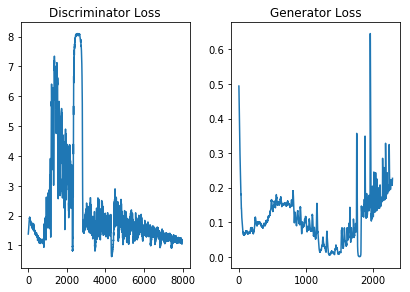

In [47]:
figure,axis = plt.subplots(1,2)
plt.tight_layout()
axis[0].plot(discriminator_loss)
axis[0].set_title("Discriminator Loss")
axis[1].plot(generator_loss)
axis[1].set_title("Generator Loss")

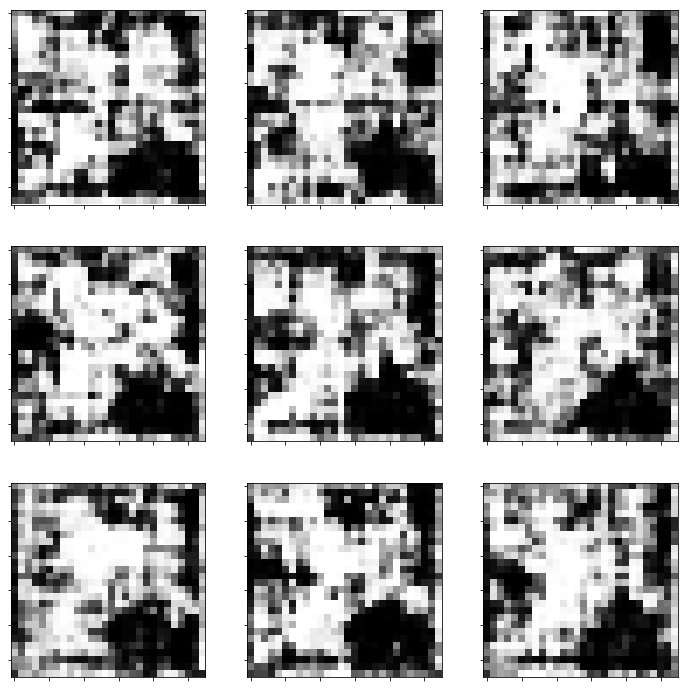

In [48]:
num_generated = 9
in_noise = np.random.rand(num_generated,100)
im = generator_model.predict(in_noise)
im = im[:,:,:,0]
figure,axis = plt.subplots(3,3,figsize=(10,10))
plt.tight_layout()
for i in range(3):
    for j in range(3):
        axis[i,j].imshow(im[i*3+j],cmap='gray')
        axis[i,j].set_yticklabels([])
        axis[i,j].set_xticklabels([])

In [49]:
discriminator_model.save_weights('discriminator_model.h5')
model.save_weights('generator_model.h5')